In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torch.nn.functional import normalize
import numpy as np

# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
#dataset = ImageFolder('/workspaces/finetune/combined_classes', transform=transform)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# Load and modify the ResNet-50 model
model = resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Remove the fully connected layer
model = model.to(device)
model.eval()

# Function to extract embeddings
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        embeddings = []
        labels = []
        for images, target in dataloader:
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb)
            labels.extend(target)
        embeddings = torch.cat(embeddings, 0)
        return embeddings, labels

# Extract embeddings
embeddings, labels = extract_embeddings(dataloader, model)

# Normalize embeddings
embeddings = normalize(embeddings)

# Example similarity search
def find_similar_images(query_embedding, embeddings, top_k=5):
    cos_similarities = torch.mm(query_embedding, embeddings.T)
    _, top_indices = torch.topk(cos_similarities, top_k, dim=1)
    return top_indices

/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.cache/pypoetry/virtualenvs/finetune-f9B3-yHi-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
from PIL import Image

# Path to the query image
query_image_path = '/workspaces/finetune/combined_classes/2994926933/2994926933(2).jpg'

# Load the image
query_image = Image.open(query_image_path).convert('RGB')

# Transform the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

query_img_tensor = transform(query_image).unsqueeze(0)  # Add batch dimension


In [11]:
# Assuming the model and device setup from previous example
query_embedding = model(query_img_tensor.to(device))
query_embedding = normalize(query_embedding)


In [16]:
def find_similar_images(query_embedding, embeddings, top_k=5):
    cos_similarities = torch.mm(query_embedding, embeddings.T)
    top_values, top_indices = torch.topk(cos_similarities, top_k, dim=1)
    return top_indices, top_values

# Perform the search
top_similar_indices, top_similar_scores = find_similar_images(query_embedding, embeddings)
print("Indices of top similar images:", top_similar_indices)

# Assuming you want to display these images or retrieve their paths
similar_image_paths = [dataset.imgs[idx][0] for idx in top_similar_indices[0].tolist()]
print("Paths of similar images:", similar_image_paths)

Indices of top similar images: tensor([[  0,   1, 117, 464,   2]])
Paths of similar images: ['/workspaces/finetune/combined_classes/2994926933/2994926933(2).jpg', '/workspaces/finetune/combined_classes/2994926933/2994926933(3).jpg', '/workspaces/finetune/combined_classes/2999489942/2999489942(5).jpg', '/workspaces/finetune/combined_classes/3001742897/3001742897(3).jpg', '/workspaces/finetune/combined_classes/2994926933/2994926933(4).jpg']


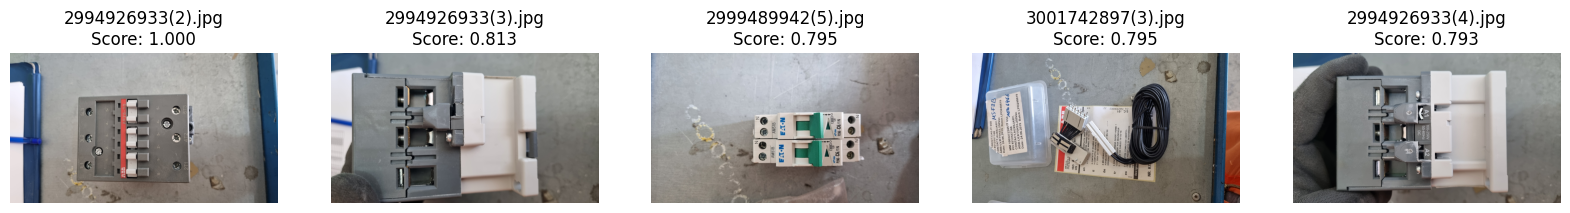

In [19]:
import matplotlib.pyplot as plt

# Retrieve the paths of the top similar images and scores
similar_image_paths = [dataset.imgs[idx][0] for idx in top_similar_indices[0].tolist()]
similar_scores = top_similar_scores[0].detach().cpu().numpy()  # Detach and convert scores to a NumPy array

# Display images and similarity scores
fig, axes = plt.subplots(1, len(similar_image_paths), figsize=(20, 5))
for ax, img_path, score in zip(axes, similar_image_paths, similar_scores):
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{img_path.split('/')[-1]}\nScore: {score:.3f}")
plt.show()